In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import warnings
import geopandas as gpd
from scipy.cluster import hierarchy
from sklearn import metrics
from scipy.cluster import vq
import sklearn.cluster as skc
import seaborn as sns
import pathlib
import pytest

import numpy as np
import pandas as pd
import geopandas as gpd 
import xarray as xr 
from shapely.geometry import Polygon, MultiPolygon
from collections import namedtuple

import FINE.spagat.dataset as spd
import FINE.spagat.representation as spr

import FINE as fn
import FINE.spagat.dataset as spd
import FINE.spagat.grouping as spg
import FINE.spagat.representation as spr 
import FINE.spagat.grouping_utils as gu
from FINE.IOManagement import dictIO
import FINE.IOManagement.xarrayIO as xrIO

from MATES import OptimizationManager



In [32]:
color_list = ['blue', 'purple', 'aquamarine', 'orange', 'green', 'red', 'coral', 'magenta', 'yellow', 'violet', 
              'brown', 'olive', 'pink', 'grey', 'lime']

color_palette = sns.color_palette(None, 30)

## dataset - multi_node_test_esM_init (Germany)

In [ ]:
def getData():
    inputDataPath = r'C:\Users\s.patil\Documents\code\fine\examples\Multi-regional_Energy_System_Workflow\InputData'
    data = {}

    # Onshore data
    capacityMax = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'Wind', 'maxCapacityOnshore_GW_el.xlsx'),
                                index_col=0, squeeze=True)
    operationRateMax = pd.read_excel(
        os.path.join(inputDataPath, 'SpatialData_Germany', 'Wind', 'maxOperationRateOnshore_el.xlsx'),
                                                  header = 0, index_col = 0)

    data.update({'Wind (onshore), capacityMax': capacityMax})
    data.update({'Wind (onshore), operationRateMax': operationRateMax})

    # Offshore data
    capacityMax = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'Wind', 'maxCapacityOffshore_GW_el.xlsx'),
                                index_col=0, squeeze=True)
    operationRateMax = pd.read_excel(
        os.path.join(inputDataPath, 'SpatialData_Germany', 'Wind', 'maxOperationRateOffshore_el.xlsx'),
                                                  header = 0, index_col = 0)

    data.update({'Wind (offshore), capacityMax': capacityMax})
    data.update({'Wind (offshore), operationRateMax': operationRateMax})

    # PV data
    capacityMax = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'PV', 'maxCapacityPV_GW_el.xlsx'),
                                index_col=0, squeeze=True)
    operationRateMax = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'PV', 'maxOperationRatePV_el.xlsx'),
                                                  header = 0, index_col = 0)

    data.update({'PV, capacityMax': capacityMax})
    data.update({'PV, operationRateMax': operationRateMax})

    # Run of river data
    capacityFix = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'HydroPower', 'fixCapacityROR_GW_el.xlsx'),
                                index_col=0, squeeze=True)
    operationRateFix = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'HydroPower',
                                                  'fixOperationRateROR.xlsx'),
                                                  header = 0, index_col = 0)

    data.update({'Existing run-of-river plants, capacityFix': capacityFix})
    data.update({'Existing run-of-river plants, operationRateFix': operationRateFix})

    # Biogas data
    operationRateMax = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'Biogas',
                                                  'biogasPotential_GWh_biogas.xlsx'),
                                                  header = 0, index_col = 0)

    data.update({'Biogas, operationRateMax': operationRateMax})

    biogasCommodityCostTimeSeries = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'Biogas',
                                                  'biogasPriceTimeSeries_MrdEuro_GWh.xlsx'),
                                                  header = 0, index_col = 0)

    data.update({'Biogas, commodityCostTimeSeries': biogasCommodityCostTimeSeries})

    # Natural gas data
    naturalGasCommodityCostTimeSeries = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'NaturalGas',
                                                  'naturalGasPriceTimeSeries_MrdEuro_GWh.xlsx'),
                                                  header = 0, index_col = 0)

    data.update({'Natural Gas, commodityCostTimeSeries': naturalGasCommodityCostTimeSeries})

    # Natural gas plant data
    capacityMax = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'NaturalGasPlants',
                                             'existingCombinedCycleGasTurbinePlantsCapacity_GW_el.xlsx'),
                                index_col=0, squeeze=True)

    data.update({'Existing CCGT plants (methane), capacityMax': capacityMax})

    # Hydrogen salt cavern data
    capacityMax = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'GeologicalStorage',
                                             'existingSaltCavernsCapacity_GWh_methane.xlsx'),
                                index_col=0, squeeze=True) * 3 / 10

    data.update({'Salt caverns (hydrogen), capacityMax': capacityMax})

    # Methane salt cavern data
    capacityMax = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'GeologicalStorage',
                                             'existingSaltCavernsCapacity_GWh_methane.xlsx'),
                                index_col=0, squeeze=True)

    data.update({'Salt caverns (methane), capacityMax': capacityMax})

    # Pumped hydro storage data
    capacityFix = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'HydroPower',
                                             'fixCapacityPHS_storage_GWh_energyPHS.xlsx'),
                                index_col=0, squeeze=True)

    data.update({'Pumped hydro storage, capacityFix': capacityFix})

    # AC cables data
    capacityFix = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'ElectricGrid',
                                             'ACcableExistingCapacity_GW_el.xlsx'),
                                index_col=0, header=0)

    data.update({'AC cables, capacityFix': capacityFix})

    reactances = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'ElectricGrid',
                                            'ACcableReactance.xlsx'),
                                index_col=0, header=0)

    data.update({'AC cables, reactances': reactances})

    # DC cables data
    capacityFix = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'ElectricGrid',
                                             'DCcableExistingCapacity_GW_el.xlsx'),
                                index_col=0, header=0)
    distances = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'ElectricGrid',
                                           'DCcableLength_km.xlsx'),
                              index_col=0, header=0)
    losses = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'ElectricGrid',
                                        'DCcableLosses.xlsx'),
                           index_col=0, header=0)

    data.update({'DC cables, capacityFix': capacityFix})
    data.update({'DC cables, distances': distances})
    data.update({'DC cables, losses': losses})

    # Pipelines data
    eligibility = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'Pipelines',
                                             'pipelineIncidence.xlsx'), index_col=0, header=0)
    distances = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'Pipelines', 'pipelineLength.xlsx'),
                              index_col=0, header=0)

    data.update({'Pipelines, eligibility': eligibility})
    data.update({'Pipelines, distances': distances})

    # Electricity demand data
    operationRateFix = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'Demands',
                                                  'electricityDemand_GWh_el.xlsx'),
                                                  header = 0, index_col = 0)

    data.update({'Electricity demand, operationRateFix': operationRateFix})

    # Hydrogen demand data
    operationRateFix = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'Demands',
                                                  'hydrogenDemand_GWh_hydrogen.xlsx'),
                                                  header = 0, index_col = 0)

    data.update({'Hydrogen demand, operationRateFix': operationRateFix})

    return data

In [ ]:
data = getData()

In [ ]:
# 2. Create an energy system model instance
locations = {'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'}
commodityUnitDict = {'electricity': r'GW$_{el}$', 'methane': r'GW$_{CH_{4},LHV}$', 'biogas': r'GW$_{biogas,LHV}$',
                         'CO2': r'Mio. t$_{CO_2}$/h', 'hydrogen': r'GW$_{H_{2},LHV}$'}
commodities = {'electricity', 'hydrogen', 'methane', 'biogas', 'CO2'}
numberOfTimeSteps=8760
hoursPerTimeStep=1

esM = fn.EnergySystemModel(locations=locations, commodities=commodities, numberOfTimeSteps=8760,
                               commodityUnitsDict=commodityUnitDict,
                               hoursPerTimeStep=1, costUnit='1e9 Euro', lengthUnit='km', verboseLogLevel=0)

CO2_reductionTarget = 1


# 3. Add commodity sources to the energy system model
## 3.1. Electricity sources
### Wind onshore

esM.add(fn.Source(esM=esM, name='Wind (onshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (onshore), operationRateMax'],
                  capacityMax=data['Wind (onshore), capacityMax'],
                  investPerCapacity=1.1, opexPerCapacity=1.1*0.02, interestRate=0.08,
                  economicLifetime=20))

data['Wind (onshore), operationRateMax'].sum()


### Wind offshore

esM.add(fn.Source(esM=esM, name='Wind (offshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (offshore), operationRateMax'],
                  capacityMax=data['Wind (offshore), capacityMax'],
                  investPerCapacity=2.3, opexPerCapacity=2.3*0.02, interestRate=0.08,
                  economicLifetime=20))

data['Wind (offshore), operationRateMax'].sum()

### PV

esM.add(fn.Source(esM=esM, name='PV', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['PV, operationRateMax'], capacityMax=data['PV, capacityMax'],
                  investPerCapacity=0.65, opexPerCapacity=0.65*0.02, interestRate=0.08,
                  economicLifetime=25))

data['PV, operationRateMax'].sum()

### Exisisting run-of-river hydroelectricity plants

esM.add(fn.Source(esM=esM, name='Existing run-of-river plants', commodity='electricity',
                  hasCapacityVariable=True,
                  operationRateFix=data['Existing run-of-river plants, operationRateFix'], tsaWeight=0.01,
                  capacityFix=data['Existing run-of-river plants, capacityFix'],
                  investPerCapacity=0, opexPerCapacity=0.208))

## 3.2. Methane (natural gas and biogas)
### Natural gas
esM.add(fn.Source(esM=esM, name='Natural gas purchase', commodity='methane',
                  hasCapacityVariable=False, commodityCostTimeSeries=data['Natural Gas, commodityCostTimeSeries']))

### Biogas
esM.add(fn.Source(esM=esM, name='Biogas purchase', commodity='biogas',
                  operationRateMax=data['Biogas, operationRateMax'], hasCapacityVariable=False,
                  commodityCostTimeSeries=data['Biogas, commodityCostTimeSeries']))


## 3.3 CO2
### CO2

esM.add(fn.Source(esM=esM, name='CO2 from enviroment', commodity='CO2',
                  hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))


# 4. Add conversion components to the energy system model

### Combined cycle gas turbine plants

esM.add(fn.Conversion(esM=esM, name='CCGT plants (methane)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'methane':-1/0.625, 'CO2':201*1e-6/0.625},
                      hasCapacityVariable=True,
                      investPerCapacity=0.65, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))


### New combined cycle gas turbine plants for biogas

esM.add(fn.Conversion(esM=esM, name='New CCGT plants (biogas)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'biogas':-1/0.635},
                      hasCapacityVariable=True,
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))


### New combined cycly gas turbines for hydrogen

esM.add(fn.Conversion(esM=esM, name='New CCGT plants (hydrogen)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True,
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### Electrolyzers

esM.add(fn.Conversion(esM=esM, name='Electroylzers', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.7},
                      hasCapacityVariable=True,
                      investPerCapacity=0.5, opexPerCapacity=0.5*0.025, interestRate=0.08,
                      economicLifetime=10))

### rSOC

capexRSOC=1.5

esM.add(fn.Conversion(esM=esM, name='rSOEC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.6},
                      hasCapacityVariable=True,
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

esM.add(fn.Conversion(esM=esM, name='rSOFC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True,
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))


# 5. Add commodity storages to the energy system model
## 5.1. Electricity storage
### Lithium ion batteries

esM.add(fn.Storage(esM=esM, name='Li-ion batteries', commodity='electricity',
                   hasCapacityVariable=True, chargeEfficiency=0.95,
                   cyclicLifetime=10000, dischargeEfficiency=0.95, selfDischarge=1-(1-0.03)**(1/(30*24)),
                   chargeRate=1, dischargeRate=1, doPreciseTsaModeling=False,
                   investPerCapacity=0.151, opexPerCapacity=0.002, interestRate=0.08,
                   economicLifetime=22))

## 5.2. Hydrogen storage
### Hydrogen filled salt caverns

esM.add(fn.Storage(esM=esM, name='Salt caverns (hydrogen)', commodity='hydrogen',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=133,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (hydrogen), capacityMax'],
                   investPerCapacity=0.00011, opexPerCapacity=0.00057, interestRate=0.08,
                   economicLifetime=30))


## 5.3. Methane storage
### Methane filled salt caverns

esM.add(fn.Storage(esM=esM, name='Salt caverns (biogas)', commodity='biogas',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=443,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (methane), capacityMax'],
                   investPerCapacity=0.00004, opexPerCapacity=0.00001, interestRate=0.08,
                   economicLifetime=30))


## 5.4 Pumped hydro storage
### Pumped hydro storage

esM.add(fn.Storage(esM=esM, name='Pumped hydro storage', commodity='electricity',
                   chargeEfficiency=0.88, dischargeEfficiency=0.88,
                   hasCapacityVariable=True, selfDischarge=1-(1-0.00375)**(1/(30*24)),
                   chargeRate=0.16, dischargeRate=0.12, capacityFix=data['Pumped hydro storage, capacityFix'],
                   investPerCapacity=0, opexPerCapacity=0.000153))


# 6. Add commodity transmission components to the energy system model
## 6.1. Electricity transmission
### AC cables

esM.add(fn.LinearOptimalPowerFlow(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix'],
                                  reactances=data['AC cables, reactances']))

### DC cables

esM.add(fn.Transmission(esM=esM, name='DC cables', commodity='electricity', losses=data['DC cables, losses'],
                        distances=data['DC cables, distances'],
                        hasCapacityVariable=True, capacityFix=data['DC cables, capacityFix']))


## 6.2 Methane transmission
### Methane pipeline

esM.add(fn.Transmission(esM=esM, name='Pipelines (biogas)', commodity='biogas',
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=False, bigM=300,
                            capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                            investPerCapacity=0.000037, investIfBuilt=0.000314,
                            interestRate=0.08, economicLifetime=40))

## 6.3 Hydrogen transmission
### Hydrogen pipelines

esM.add(fn.Transmission(esM=esM, name='Pipelines (hydrogen)', commodity='hydrogen',
                            distances=data['Pipelines, distances'],
                            hasCapacityVariable=True, hasIsBuiltBinaryVariable=False, bigM=300,
                            locationalEligibility=data['Pipelines, eligibility'],
                            capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                            investPerCapacity=0.000177, investIfBuilt=0.00033,
                            interestRate=0.08, economicLifetime=40))

# 7. Add commodity sinks to the energy system model
## 7.1. Electricity sinks
### Electricity demand

esM.add(fn.Sink(esM=esM, name='Electricity demand', commodity='electricity',
                    hasCapacityVariable=False, operationRateFix=data['Electricity demand, operationRateFix']))

## 7.2. Hydrogen sinks
### Fuel cell electric vehicle (FCEV) demand

FCEV_penetration=0.5
esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                    operationRateFix=data['Hydrogen demand, operationRateFix']*FCEV_penetration))

## 7.3. CO2 sinks
### CO2 exiting the system's boundary

esM.add(fn.Sink(esM=esM, name='CO2 to enviroment', commodity='CO2',
                    hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))

# 8. Optimize energy system model

# esM.cluster(numberOfTypicalPeriods=3)

# esM.optimize(timeSeriesAggregation=True, solver = solver)


In [ ]:
esM_Germany = esM

In [ ]:
shp_Germany = 'C:/Users/s.patil/Documents/code/fine/examples/Multi-regional_Energy_System_Workflow/InputData/SpatialData_Germany/shapeFiles/clusteredRegions.shp'

## dataset - EuropeanModel

In [4]:
# Input files

INPUT_PATH = 'C:/Users/s.patil/Documents/code/fine/examples/Multi-regional_Energy_System_Workflow/InputData/EuropeanModelData'

input_data = os.path.join(INPUT_PATH,'new_EuropeanScenario_Ch5_Section1_DGC.nc')
shp_Europe = os.path.join(INPUT_PATH,'supregions.shp')



In [5]:
opM = OptimizationManager(input_data,
                          commodityUnitsDict={'electricity': 'GW_el', 
                                              'hydrogen': 'GW_h2', 
                                              'water': 'GW_wt', 
                                              'waterRes':'GW_wt', 
                                              'biomass':'GW_bio'})

In [6]:
esM_Europe = opM.setup()

The distances of a component are set to a normalized value of 1.


## Spatial grouping - sklearn hierarchical 

In [7]:
aggregation_function_dict = {'operationRateMax': ('weighted mean', 'capacityMax'),#
                              'operationRateFix': ('sum', None),
                              'locationalEligibility': ('bool', None),
                              'capacityMax': ('sum', None),
                              'investPerCapacity': ('mean', None),
                              'investIfBuilt': ('bool', None),
                              'opexPerOperation': ('mean', None),
                              'opexPerCapacity': ('mean', None),
                              'opexIfBuilt': ('bool', None),
                              'interestRate': ('mean', None),
                              'economicLifetime': ('mean', None),
                              'capacityFix': ('sum', None),
                              'losses': ('mean', None),
                              'distances': ('mean', None),
                              'commodityCost': ('mean', None),
                              'commodityRevenue': ('mean', None),
                              'opexPerChargeOperation': ('mean', None),
                              'opexPerDischargeOperation': ('mean', None),
                              'QPcostScale': ('sum', None), 
                              'technicalLifetime': ('sum', None),
                              'reactances': ('sum', None), 
                              }

### Germany

In [ ]:
# Output files 
n_regions = 4
groupingResult_xr_file = f'groupingResult_{n_regions}reg.nc4'
groupingResult_shp_file = f'groupingResult_{n_regions}reg.shp'

In [ ]:
aggregated_esM = esM_Germany.aggregateSpatially(shapefilePath = shp_Germany, 
                                                grouping_mode='parameter_based', 
                                                nRegionsForRepresentation = n_regions,
                                                aggregatedResultsPath = '.',
                                                sds_region_filename=groupingResult_shp_file,
                                                sds_xr_dataset_filename=groupingResult_xr_file) 

In [ ]:
fig, ax = fn.plotLocations(groupingResult_shp_file, 
                           plotLocNames=False, 
                           indexColumn='space',
                           faceColor=color_list)

### Europe

In [21]:
# Output files 
n_regions = 15
groupingResult_xr_file = f'groupingResult_{n_regions}reg.nc4'
groupingResult_shp_file = f'groupingResult_{n_regions}reg.shp'

In [22]:
aggregated_esM = esM_Europe.aggregateSpatially(shapefilePath = shp_Europe, 
                                                grouping_mode='parameter_based', 
                                                nRegionsForRepresentation = n_regions,
                                                aggregatedResultsPath = '.',
                                                sds_region_filename=groupingResult_shp_file,
                                                sds_xr_dataset_filename=groupingResult_xr_file) 

Performing parameter-based clustering on the regions.


 c:\users\s.patil\documents\code\fine\FINE\spagat\grouping_utils.py:237: UserWarning:Variable gpd_geometries has dimensions ('space',) which are not considered for spatial aggregation.
 c:\users\s.patil\documents\code\fine\FINE\spagat\grouping_utils.py:237: UserWarning:Variable gpd_centroids has dimensions ('space',) which are not considered for spatial aggregation.
 c:\users\s.patil\documents\code\fine\FINE\spagat\grouping_utils.py:237: UserWarning:Variable centroid_distances has dimensions ('space', 'space_2') which are not considered for spatial aggregation.


The cophenetic correlation coefficient of the hiearchical clustering is  0.7121747361352841
Inconsistencies: [0.0, 0.0, 0.0, 0.7071067811865486, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7071067811865528, 0.0, 0.7071067811880829, 0.7071067811865469, 0.0, 0.7071067811865487, 0.7071067811865529, 0.7071067811865474, 0.7071067811865508, 0.7071067811865459, 0.6542387016444168, 0.0, 0.0, 0.7071067811865451, 0.707106781186556, 0.0, 0.0, 0.0, 0.0, 0.7747202761022581, 0.0, 0.7071067811865561, 0.8643695527546729, 0.7071067811865477, 0.7071067811862226, 0.0, 0.0, 0.7071067811865089, 0.7071067811865512, 0.707106781186535, 0.0, 0.0, 0.0, 0.7071067811865425, 0.7071067811865475, 1.0097331146617214, 0.707106781186548, 1.017155815024377, 0.9199254279365316, 0.7071067811874098, 0.0, 0.0, 0.0, 0.707106781186571, 1.0440295850902683, 0.7071067811865474, 0.7725255618182695, 0.7071067811865478, 1.1078974018426155, 0.7071067811829218, 0.7071067811865467, 1.046989499593277, 0.7071067811865565, 0.8525780709767388, 1.1280

 c:\users\s.patil\documents\code\fine\FINE\spagat\representation.py:120: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
 c:\users\s.patil\documents\code\fine\FINE\utils.py:1049: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\s.patil\documents\code\fine\FINE\utils.py:1049: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\s.patil\documents\code\fine\FINE\utils.py:1049: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:

elapsed time for save_sds: 0.10 minutes


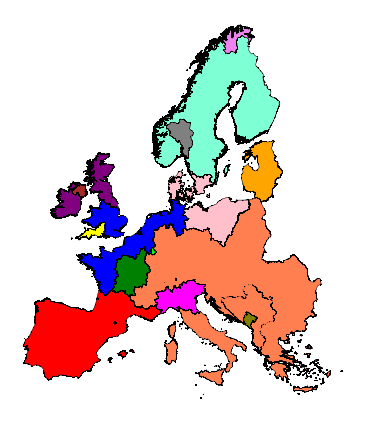

In [33]:
fig, ax = fn.plotLocations(groupingResult_shp_file, 
                           plotLocNames=False, 
                           indexColumn='space',
                          faceColor=color_list)                         

In [17]:
color_palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]